# Notebook for the treatment of powder XRD and thermo-XRD data

This notebook has been conceived to represent and treat powder-XRD data from csv-formatted files (xy, dat, txt, csv, etc.). It covers the representation of XRD diffractograms as a function of temperature as:
- overlapping plots
- colormaps

It allso allows the fit of powder-XRD using the xrayutilities packages.

In case that you want to load files directly from .ras data, please use the following function, on which the range of 2th must be provided:

In [ ]:
def acdata(rasname, range_th):
    trans = 90667 # translation
    scaley = 10 # multiplication : Inew=Iold*scaley+trans
    
    
    d = xu.io.RASFile(rasname, path='')
    tt,Int=[],[]
    for num,val in enumerate(d.scans[-1].data[d.scan.scan_axis]):
        if val>=range_tt[0] and val<=range_tt[1]:
            tt.append(val)
            if val>=range_tt2[0] and val<=range_tt2[1]:
                Int.append(d.scans[-1].data['int'][num]*scaley+trans)
            else:
                Int.append(d.scans[-1].data['int'][num])
    tt,Int=np.array(tt),np.array(Int)
    
    return tt, Int

## Relevant modules:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from scipy.signal import find_peaks
import xrayutilities as xu

%matplotlib inline

## Code start and file location

We locate the home working directory:

In [2]:
home_cwd = os.getcwd()

We filter the relevant files among all files and build a dataframe out of them. In my case, I want all '.xy' files whithout "complement" word on them, just change according to your likings:

In [2]:
file_list = list(filter(lambda x: ('xy' in x) and ('complement' not in x), os.listdir()))

In [3]:
file_df = pd.DataFrame(file_list, columns=['file',])

I locate the temperature value, transform into Kelvin and then into int value:

In [4]:
file_df['T'] = file_df['file'].apply(lambda x: x[x.find('temperatue=')+11:x.find('.xy')]).astype(float)+273.15

In [5]:
file_df['T'] = file_df['T'].astype(int)

I sort the dataframe according to the T values and round the T values down:

In [8]:
T_df = file_df.sort_values('T', ascending=False).reset_index().drop('index', axis=1)

In [9]:
T_df['T'] -= 3

We take one sample file and open it:

In [10]:
file = T_df.loc[0]['file']

In [11]:
df = pd.read_csv(file, sep='  ', engine='python', skiprows=3, names=['2th','Nan', 'Nan2', 'I'])
df['I'] = df['I'].fillna(df['Nan2'])
df.drop(['Nan', 'Nan2'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10394 entries, 0 to 10393
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2th     10394 non-null  float64
 1   I       10394 non-null  float64
dtypes: float64(2)
memory usage: 162.5 KB


In case you want to detect the peaks - I will not use this for anything, though

In [12]:
# find peaks in the 'I' column
peaks, _ = find_peaks(df['I'], prominence=35)

# get the corresponding '2th' values
peaks_2th = df['2th'][peaks]

In [13]:
df['I'] = df['I'] - df['I'].min()

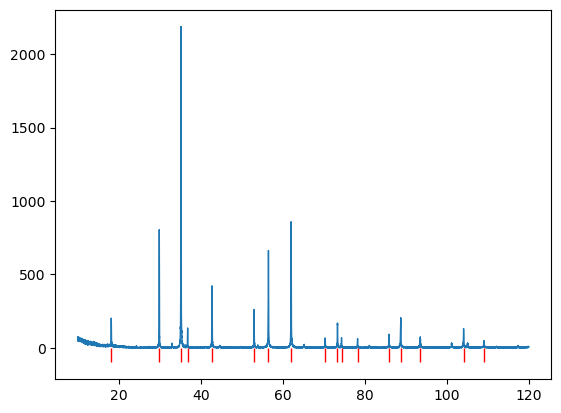

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=1)

axs.plot(df['2th'], df['I'], lw=1)
for peak in peaks_2th:
    axs.vlines(x=peak, ymin=-100, ymax=0, color='red', lw=1, )

Among all temperatures, I choose the ones that I want for the representation:

In [15]:
T_df['T'].values

array([300, 300, 290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190,
       180, 170, 160, 150, 140, 130, 120, 110, 100,  90])

In [17]:
T_inter = [300, 200, 140, 130, 110, 100, 90]

I filter dataframe with selected T:

In [18]:
T_filter = T_df[T_df['T'].isin(T_inter)].drop(0, axis=0).reset_index()

In [19]:
T_filter 

,index,file,T
0,1,FVO_thermodiffraction_-180_RT_range_023_temper...,300
1,11,FVO_thermodiffraction_-180_RT_range_013_temper...,200
2,17,FVO_thermodiffraction_-180_RT_range_007_temper...,140
3,18,FVO_thermodiffraction_-180_RT_range_006_temper...,130
4,20,FVO_thermodiffraction_-180_RT_range_004_temper...,110
5,21,FVO_thermodiffraction_-180_RT_range_003_temper...,100
6,22,FVO_thermodiffraction_-180_RT_range_002_temper...,90


## Diffractogram representation as overlapping plots:

Representation as function of T. Modify the increment of the "spacer" variable at the end to change the interplot distance.

Text(0.5, 0, '2θ (°)')

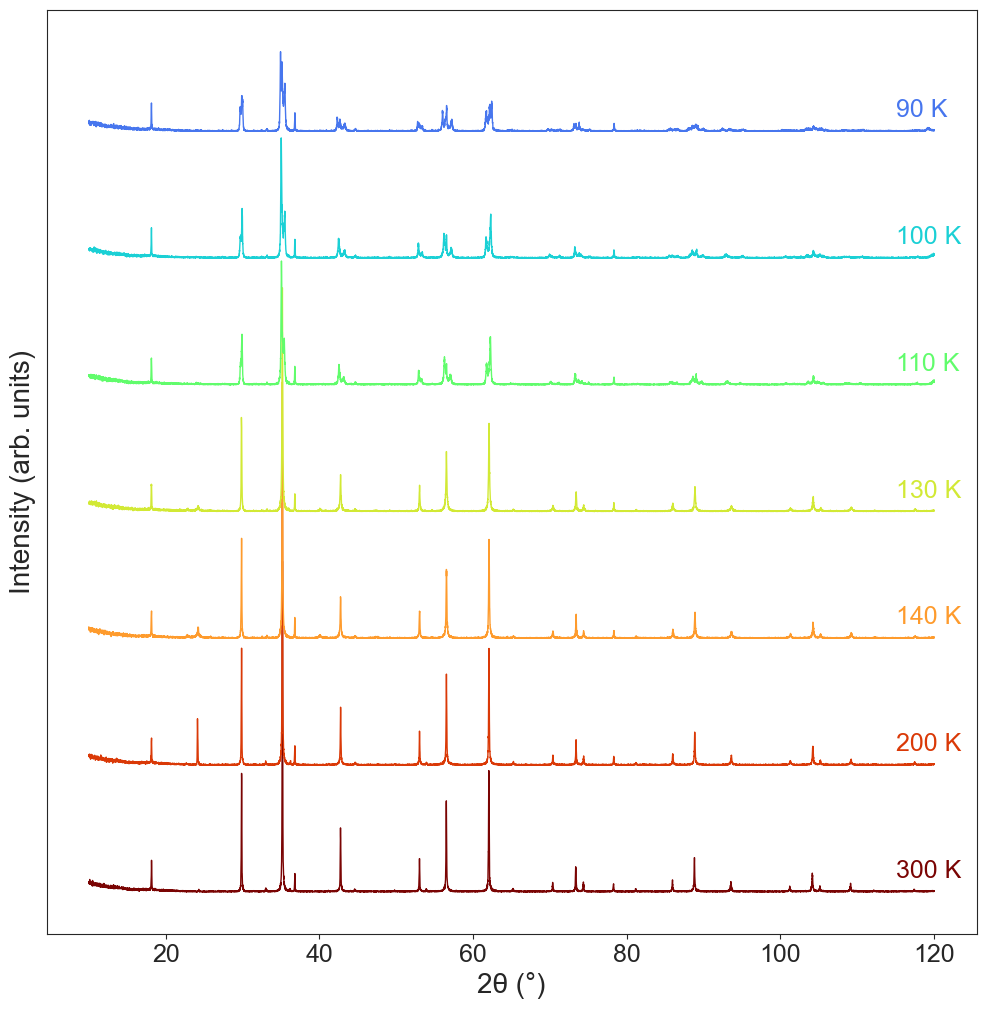

In [21]:
# set the starting color and increment for each line
start_color = 1.0
color_increment = -1.0 / len(T_filter['file'])

# for the colors:
cmap = plt.cm.get_cmap('turbo')

plt.rcParams['font.size'] = 18
# create the plot
spacer = 0
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
sns.set_style('ticks')

for i, file in enumerate(T_filter['file']):
    # read the data from the file
    df = pd.read_csv(file, sep='  ', engine='python', skiprows=3, names=['2th','Nan', 'Nan2', 'I'])
    df['I'] = df['I'].fillna(df['Nan2'])
    df.drop(['Nan', 'Nan2'], axis=1, inplace=True)
    
    # find peaks in the 'I' column
    peaks, _ = find_peaks(df['I'], prominence=35)

    # get the corresponding '2th' values
    peaks_2th = df['2th'][peaks]
    
    df['I'] = df['I'] - df['I'].min()
    
    # add a spacer to separate each line
    df['I_cor'] = df['I'] + spacer
    
    # set the color for this line using the colormap
    color = cmap(start_color)
    start_color += color_increment
    

    # plot the line with the specified color
    axs.plot(df['2th'], df['I_cor'], color=color, lw=1)
    axs.text(115, spacer+100, str(T_filter.loc[i]['T']) + ' K', color=color)
    
    # increment the spacer for the next line
    spacer += 900
axs.set_yticks([])
axs.set_ylabel('Intensity (arb. units)', fontsize=20)
axs.set_xlabel('2θ (°)', fontsize=20)

Plot with zoommed areas to see the evolution:

Text(0.5, 0.05, '2θ (°)')

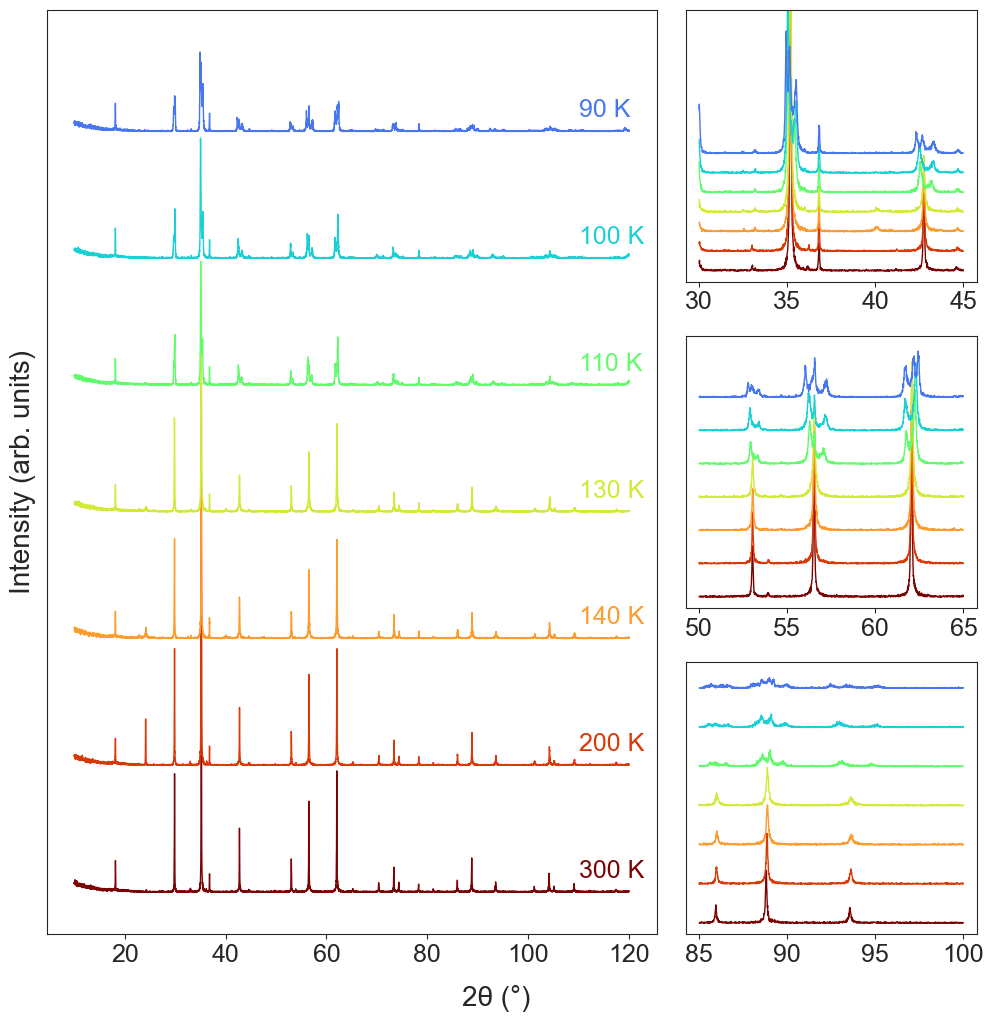

In [23]:
# set the starting color and increment for each line
start_color = 1.0
color_increment = -1.0 / len(T_filter['file'])

plt.rcParams['font.size'] = 18
# create the plot
spacer = 0
fig = plt.figure(figsize=(12, 12))
axs = plt.subplot2grid((3, 3), (0, 0), rowspan=4, colspan=2)
ax1 = plt.subplot2grid((3, 3), (0, 2), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((3, 3), (1, 2), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((3, 3), (2, 2), rowspan=1, colspan=1)
sns.set_style('ticks')
plt.subplots_adjust(hspace=0.2, wspace=0.1)
for i, file in enumerate(T_filter['file']):
    # read the data from the file
    df = pd.read_csv(file, sep='  ', engine='python', skiprows=3, names=['2th','Nan', 'Nan2', 'I'])
    df['I'] = df['I'].fillna(df['Nan2'])
    df.drop(['Nan', 'Nan2'], axis=1, inplace=True)
    
    # find peaks in the 'I' column
    peaks, _ = find_peaks(df['I'], prominence=35)

    # get the corresponding '2th' values
    peaks_2th = df['2th'][peaks]
    
    df['I'] = df['I'] - df['I'].min()
    
    # add a spacer to separate each line
    df['I_cor'] = df['I'] + spacer
    df['2th_moved'] = df['2th'] + i*0
    df['I_mini'] = df['I'] + spacer*0.1
    df['I_mini_2'] = df['I'] + spacer*0.17
    df['I_mini_3'] = df['I'] + spacer*0.2
    # set the color for this line using the colormap
    color = cmap(start_color)
    start_color += color_increment
    

    # plot the line with the specified color
    axs.plot(df['2th'], df['I_cor'], color=color, lw=1)
    ax1.plot(df[(df['2th'] > 30) & (df['2th'] < 45)]['2th_moved'], df[(df['2th'] > 30) & (df['2th'] < 45)]['I_mini'], color=color, lw=1)
    ax2.plot(df[(df['2th'] > 50) & (df['2th'] < 65)]['2th_moved'], df[(df['2th'] > 50) & (df['2th'] < 65)]['I_mini_2'], color=color, lw=1)
    ax3.plot(df[(df['2th'] > 85) & (df['2th'] < 100)]['2th_moved'], df[(df['2th'] > 85) & (df['2th'] < 100)]['I_mini_3'], color=color, lw=1)
    
    
    axs.text(110, spacer+100, str(T_filter.loc[i]['T']) + ' K', color=color)
    
    # increment the spacer for the next line
    spacer += 900
axs.set_yticks([])
ax_list = [ax1, ax2, ax3]
for ax in ax_list:
    ax.set_ylim(-50, 1200)
    ax.locator_params(nbins=6)
    ax.set_yticks([])
axs.set_ylabel('Intensity (arb. units)', fontsize=20)
fig.text(0.5, 0.05, '2θ (°)', ha='center', fontsize=20)
#plt.savefig('PowderXRD-asT.png', dpi=1000, bbox_inches='tight')

## Figure with all T, colormap

I get rid of the first file because it is a repeated temperature:

In [24]:
T_df_c = T_df.drop(0, axis=0)

Numpy array of (T) X (2th) size to save the data:

In [28]:
I_np = np.zeros((len(T_df_c), len(df)))

In [29]:
len_list = []
for i, file in enumerate(T_df_c['file']):
        # read the data from the file
    df = pd.read_csv(file, sep='  ', engine='python', skiprows=3, names=['2th','Nan', 'Nan2', 'I'])
    df['I'] = df['I'].fillna(df['Nan2'])
    I_np[i, :] = df['I'] + 1

Text(0.5, 0, '2θ (°)')

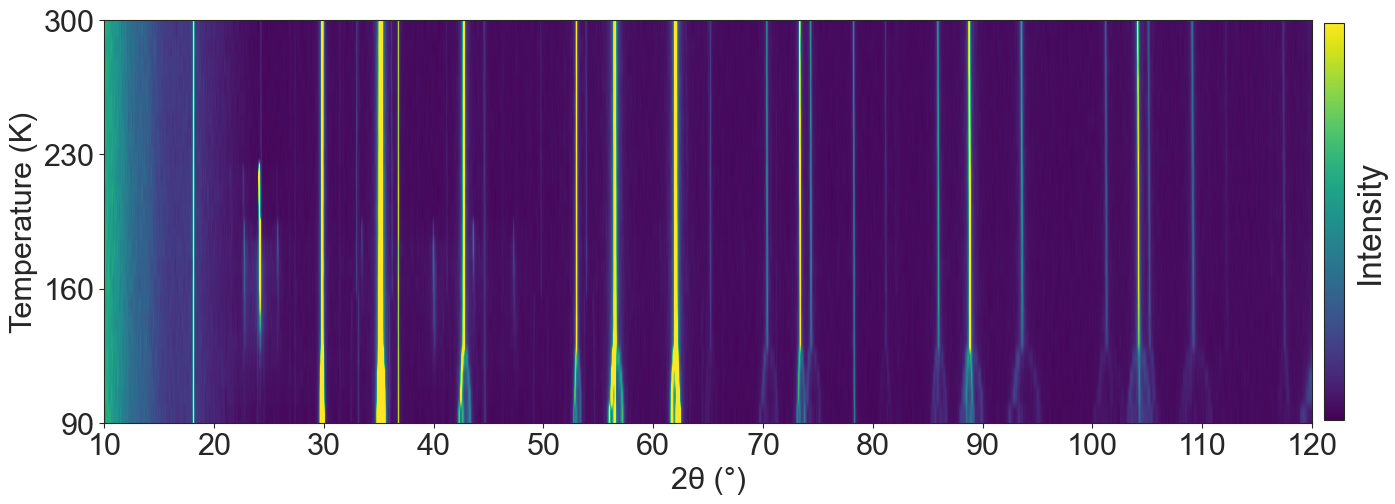

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
plt.rcParams['font.size'] = 24
# Display the array with imshow
im = axs.imshow(I_np, cmap='viridis', extent=[0,6,0,2], vmin=0, vmax=100)


cbar = fig.colorbar(im, ax=axs, label='Intensity', pad=0.01, fraction=0.016)
cbar.ax.set_yticks([])
axs.set_ylabel('T (K)')

# Set the y-tick labels
yticks = np.linspace(0, 2, 4)
ytick_labels = np.linspace(90, 300, 4, dtype=int)
axs.set_yticks(yticks)
axs.set_yticklabels(ytick_labels)

axs.set_ylabel('T (K)')

xticks = np.linspace(0, 6, 12)
xtick_labels = np.linspace(10, 120, 12, dtype=int)
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels)

axs.set_ylabel('Temperature (K)')
axs.set_xlabel('2θ (°)')
#plt.savefig('PowderXRD-asT-FVO_cm.png', dpi=1000, bbox_inches='tight')

## Fit of powder-XRD spectra using xrayutilities

We load experimental data and take the 2th and I columns:

In [40]:
X_exp = pd.read_csv(T_df_c.loc[1]['file'], skiprows=3, engine='python', sep='    ', names=['2th', 'I'], index_col=None)
X_exp.head()

,2th,I
0,10.0000,66.0
1,10.0106,60.0
2,10.0212,62.0
3,10.0318,69.0
4,10.0423,56.0


In [41]:
tt = X_exp['2th'].to_numpy()
I = X_exp['I'].to_numpy()

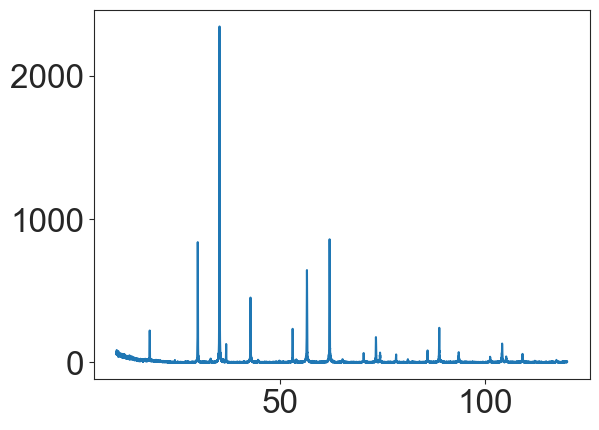

In [42]:
plt.plot(tt, I)

Define the material as a crystal:

In [47]:
FVO = xu.materials.Crystal("FVO", xu.materials.SGLattice(227, 8.453,
                                                         atoms=('Fe','V','O'),
                                                         pos=['8a','16d',('32e',0.380)]))

Create powder object:

In [49]:
FVO_powder = xu.simpack.Powder(FVO, 1,
                               crystallite_size_gauss=100e-9)

Create powder model to fi:

In [50]:
pm = xu.simpack.PowderModel(FVO_powder, I0=100)

We create parameters for the fit:

In [56]:
params = pm.create_fitparameters()
params

name,value,initial value,min,max,vary
phase_FVO_a,8.45300000,8.453,-inf,inf,False
phase_FVO_at2_O_32e_0_pos,0.38000000,0.38,-inf,inf,False
phase_FVO_at0_Fe_8a_occupation,1.00000000,1.0,-inf,inf,False
phase_FVO_at1_V_16d_occupation,1.00000000,1.0,-inf,inf,False
phase_FVO_at2_O_32e_occupation,1.00000000,1.0,-inf,inf,False
phase_FVO_at0_Fe_8a_biso,0.00000000,0.0,-inf,inf,False
phase_FVO_at1_V_16d_biso,0.00000000,0.0,-inf,inf,False
phase_FVO_at2_O_32e_biso,0.00000000,0.0,-inf,inf,False
phase_FVO_crystallite_size_gauss,1.0000e-07,1e-07,-inf,inf,False
phase_FVO_volume,1.00000000,1,-inf,inf,False


We define those that we want to change in the following way:

In [57]:
params['phase_FVO_a'].vary = True
params['phase_FVO_a'].value = 8.453

params['primary_beam_intensity'].vary = True
params['phase_FVO_crystallite_size_gauss'].vary = True
params['emission_emiss_intensities_item_0'].vary = True
params['emission_crystallite_size_gauss'].vary = True
params['background_coeff_0'].vary = True
params['classoptions_window_width'].vary = True

params['phase_FVO_at0_Fe_8a_occupation'].vary = True
params['phase_FVO_at1_V_16d_occupation'].vary = True

We fit and store the fit results in fit_result object:

In [58]:
fit_result = pm.fit(params, tt, I)

The diffractogram which is generated with the fitted parameters is stored in a fit variable:

In [59]:
fit = pm.simulate(tt)

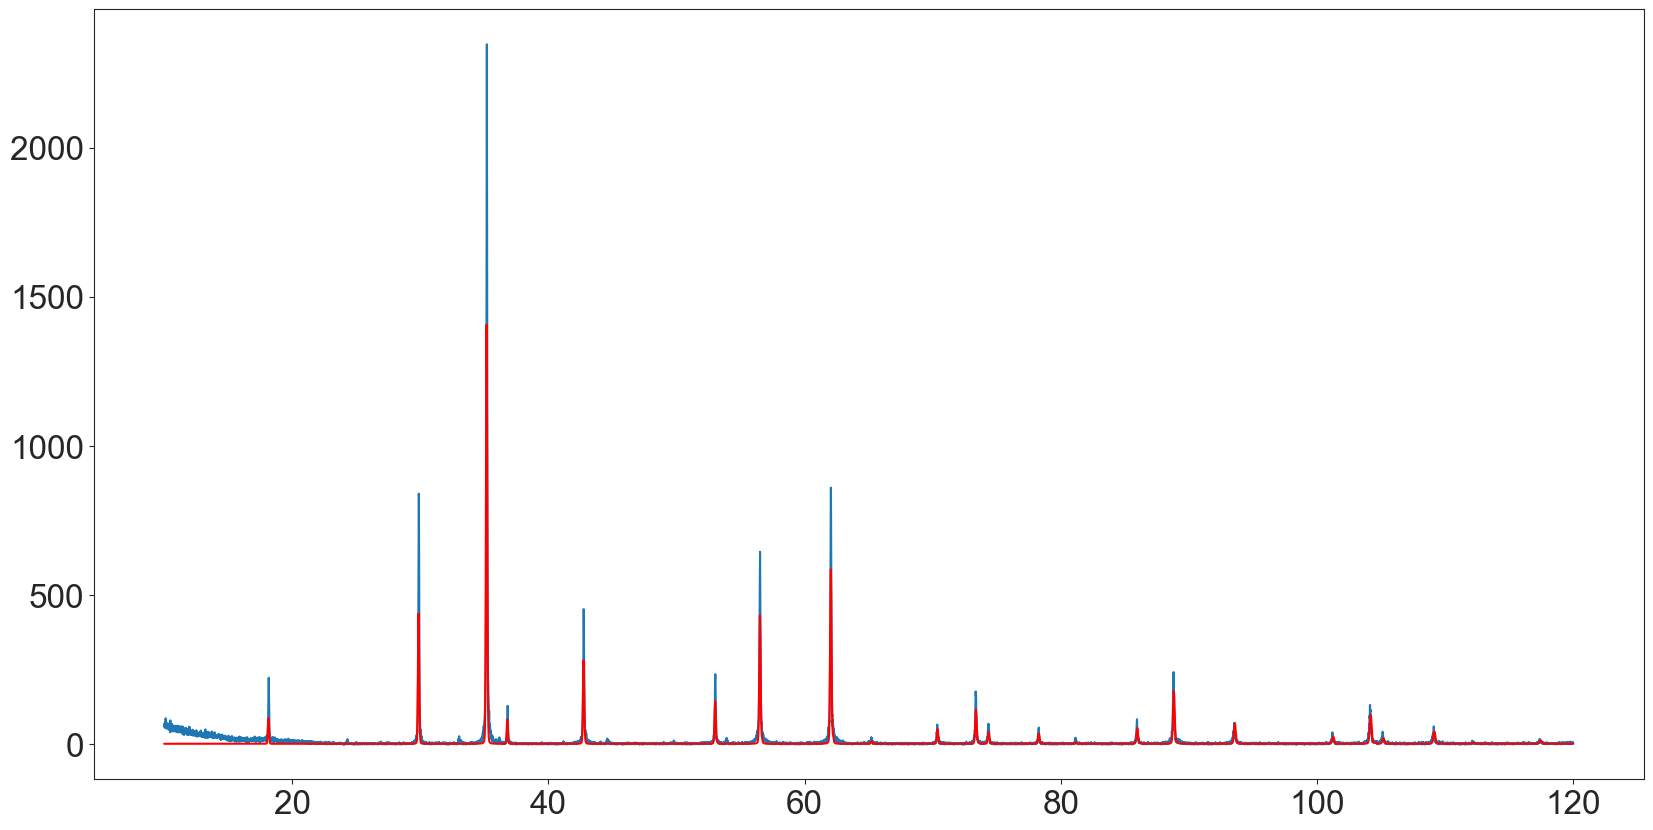

In [60]:
fig, axs = plt.subplots(1,1,figsize=(20,10))
plt.plot(tt, I)
plt.plot(tt, fit - 0.2,color='r')

We create function to do all of this with a given file, it will output the lattice parameter with the error:

In [61]:
def fit_cubic(file):
    X_exp = pd.read_csv(file, skiprows=3, engine='python', sep='    ', names=['2th', 'I'], index_col=None)
    tt = X_exp['2th'].to_numpy()
    I = X_exp['I'].to_numpy()

    FVO = xu.materials.Crystal("FVO", xu.materials.SGLattice(227, 8.453,
                                                             atoms=('Fe','V','O'),
                                                             pos=['8a','16d',('32e',0.380)]))

    FVO_powder = xu.simpack.Powder(FVO, 1,
                                   crystallite_size_gauss=100e-9)

    pm = xu.simpack.PowderModel(FVO_powder, I0=100)
    params = pm.create_fitparameters()

    params['phase_FVO_a'].value = 8.453
    params['phase_FVO_a'].vary = True
    

    params['primary_beam_intensity'].vary = True
    params['phase_FVO_crystallite_size_gauss'].vary = True
    params['emission_emiss_intensities_item_0'].vary = True
    params['emission_crystallite_size_gauss'].vary = True
    params['background_coeff_0'].vary = True
    params['classoptions_window_width'].vary = True


    params['phase_FVO_at0_Fe_8a_occupation'].vary = True
    params['phase_FVO_at1_V_16d_occupation'].vary = True
    fit_result = pm.fit(params, tt, I)
    
    fit = pm.simulate(tt)
    pm.close()
    value = str(fit_result.params['phase_FVO_a'])
    return tuple(map(lambda x: float(x), value[value.find('value=')+6:value.find(', bounds')].split(' +/- ')))
    # If you want to have the fitted diffractogram instead of the lattice parameter, replace the "return" above by this below:
    # return fit

In [62]:
fit_cubic(T_df_c.loc[1]['file'])

(8.453561652136434,)